In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import warnings; 
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

C:\Users\saurav\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
books = pd.read_csv('books.csv',sep=';',error_bad_lines=False,encoding="latin-1")
users = pd.read_csv('users.csv',sep=';',error_bad_lines=False,encoding="latin-1")
rating = pd.read_csv('rating.csv',sep=';',error_bad_lines=False,encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\saurav\Miniconda3\lib\site-packages\IPython\core\interactiveshell

In [5]:
print(books.head())
print(rating.head())
print(users.head())

         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/

In [6]:
books.columns=['ISBN','bookTitle','bookAuthor','yearOfPublication','publisher','imageUrlS','imageUrlM','imageUrlL']
rating.columns=['userId','ISBN','bookRating']
users.columns=['userId','location','age']

In [7]:
books.head(5)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
#Checking dTypes and correcting the forged / discrepant entries 
#I am adjusting the column width to display full text of columns.
print(books.dtypes)
pd.set_option('display.max_colwidth',-1)

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
imageUrlS            object
imageUrlM            object
imageUrlL            object
dtype: object


In [9]:
books.head(5)
# Now we are getting the whole name in each cells

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [10]:
## Checking the yearOfPublication for the books...
books.yearOfPublication
books.yearOfPublication.unique()
## We see there are two incorrect values in year column that is DKPublishingInc and Gallimard

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996', '0',
       '1997', '2001', '1974', '1968', '1987', '1984', '1988', '1963',
       '1956', '1970', '1985', '1978', '1973', '1980'

In [11]:
books.loc[books.yearOfPublication=='DK Publishing Inc']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/078946697X.01.LZZZZZZZ.jpg,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0789466953.01.LZZZZZZZ.jpg,NaN


In [12]:
books.loc[books.yearOfPublication=='Gallimard']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/2070426769.01.LZZZZZZZ.jpg,NaN


In [13]:
## Now we need to rectify the mistakes in the csv by interchanging the year of publication and bookAuthor
books.loc[books.ISBN=='078946697X','yearOfPublication']=2000
books.loc[books.ISBN=='078946697X','bookAuthor']='Michael Teitelbaum'
books.loc[books.ISBN=='078946697X','publisher']='DK Publishing Inc'
books.loc[books.ISBN=='078946697X','bookTitle']='DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

books.loc[books.ISBN=='0789466953','yearOfPublication']=2000
books.loc[books.ISBN=='0789466953','bookAuthor']='James Buckley'
books.loc[books.ISBN=='0789466953','publisher']='DK Publishing Inc'
books.loc[books.ISBN=='0789466953','bookTitle']='DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'

books.loc[books.ISBN=='2070426769','yearOfPublication']=2003
books.loc[books.ISBN=='2070426769','bookAuthor']='Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN=='2070426769','publisher']='Gallimard'
books.loc[books.ISBN=='2070426769','bookTitle']="Peuple du ciel, suivi de 'Les Bergers"

In [14]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030, 1911,
       1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934, 1910,
       1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901, 2010,
       1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996', '0',
       '1997', '2001', '1974', '1968', '1987', '1984', '1988', '1963',
       '1956', '1970', '1985', '1978', '1973', '1980'

In [15]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
imageUrlS            object
imageUrlM            object
imageUrlL            object
dtype: object

In [16]:
# The datatype of yearOfPublication is object and we need to convert it to INT using the pandas function to_numeric
books.yearOfPublication=pd.to_numeric(books.yearOfPublication)

In [17]:
books.dtypes
# Now we see the dtype of year is integer

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    int64 
publisher            object
imageUrlS            object
imageUrlM            object
imageUrlL            object
dtype: object

In [18]:
users.dtypes

userId      int64  
location    object 
age         float64
dtype: object

In [19]:
rating.dtypes

userId        int64 
ISBN          object
bookRating    int64 
dtype: object

In [20]:
# So now we get to see that all the dtypes that is data types are correct , so part of the cleaning process is done.

In [21]:
books.yearOfPublication.unique().max()

2050

In [22]:
# So we get to know that the values of yearOfPublication ranges till 2050 . Since he current year is 2018 , we will be discarding
# the values that are way too ahead o 2018 since they are hardly of any use to our analysis.
books.loc[(books.yearOfPublication>2018) | (books.yearOfPublication==0),'yearOfPublication']=np.NaN
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()),inplace=True)
books.yearOfPublication=books.yearOfPublication.astype(np.int32)
# When inplace=True is passed, the data is renamed in place (it returns nothing)
# When inplace=False is passed (this is the default value, so isn't necessary), performs the operation and returns a copy of the object
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 1939, 1926, 1938, 1911, 1904, 1949,
       1932, 1928, 1929, 1927, 1931, 1914, 1934, 1910, 1933, 1902, 1924,
       1921, 1900, 1944, 1917, 1901, 2010, 1908, 1906, 1935, 1806, 2012,
       2006, 1909, 2008, 1378, 1919, 1922, 1897, 1376], dtype=int64)

In [23]:
# Checking for the publisher column if there are any empty values
print(books.publisher.unique())

['Oxford University Press' 'HarperFlamingo Canada' 'HarperPerennial' ...,
 'Tempo' 'Life Works Books' 'Connaught']


In [24]:
print(books.loc[books.publisher.isnull()])

              ISBN        bookTitle       bookAuthor  yearOfPublication  \
128890  193169656X  Tyrant Moon      Elaine Corvidae  2002                
129037  1931696993  Finders Keepers  Linnea Sinclair  2001                

       publisher  \
128890  NaN        
129037  NaN        

                                                           imageUrlS  \
128890  http://images.amazon.com/images/P/193169656X.01.THUMBZZZ.jpg   
129037  http://images.amazon.com/images/P/1931696993.01.THUMBZZZ.jpg   

                                                           imageUrlM  \
128890  http://images.amazon.com/images/P/193169656X.01.MZZZZZZZ.jpg   
129037  http://images.amazon.com/images/P/1931696993.01.MZZZZZZZ.jpg   

                                                           imageUrlL  
128890  http://images.amazon.com/images/P/193169656X.01.LZZZZZZZ.jpg  
129037  http://images.amazon.com/images/P/1931696993.01.LZZZZZZZ.jpg  


In [27]:
books.loc[books.ISBN=='193169656X', 'publisher']='noDetailsFound'
books.loc[books.ISBN=='1931696993', 'publisher']='noDetailsFound'

In [28]:
print(books.loc[books.publisher.isnull()])
## This comes out to be empty dataframe which means NaN entries have been properly deleted nad replace with noDetailsFound

Empty DataFrame
Columns: [ISBN, bookTitle, bookAuthor, yearOfPublication, publisher, imageUrlS, imageUrlM, imageUrlL]
Index: []


In [30]:
print(users.age.unique())

[  nan   18.   17.   61.   26.   14.   25.   19.   46.   55.   32.   24.
   20.   34.   23.   51.   31.   21.   44.   30.   57.   43.   37.   41.
   54.   42.   50.   39.   53.   47.   36.   28.   35.   13.   58.   49.
   38.   45.   62.   63.   27.   33.   29.   66.   40.   15.   60.    0.
   79.   22.   16.   65.   59.   48.   72.   56.   67.    1.   80.   52.
   69.   71.   73.   78.    9.   64.  103.  104.   12.   74.   75.  231.
    3.   76.   83.   68.  119.   11.   77.    2.   70.   93.    8.    7.
    4.   81.  114.  230.  239.   10.    5.  148.  151.    6.  101.  201.
   96.   84.   82.   90.  123.  244.  133.   91.  128.   94.   85.  141.
  110.   97.  219.   86.  124.   92.  175.  172.  209.  212.  237.   87.
  162.  100.  156.  136.   95.   89.  106.   99.  108.  210.   88.  199.
  147.  168.  132.  159.  186.  152.  102.  116.  200.  115.  226.  137.
  207.  229.  138.  109.  105.  228.  183.  204.   98.  223.  113.  208.
  107.  157.  111.  146.  118.  220.  143.  140.  1

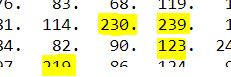

In [35]:
###### <img src="C:\Users\saurav\Desktop\code_stack_python\BookRecommend\ageError.JPG">
# we can see the ages of the users going beyond 120 which is quite rare and avbsurd if we be practical
# Moreover there are NaN values for some reasons
# Let us consider any age less than 1 and more than 100 as absurd
from IPython.display import Image
Image(filename='ageError.JPG')

In [36]:
users.loc[(users.age>100)|(users.age<1),'age']=np.nan
users.age=users.age.fillna(users.age.mean())


In [38]:
print(sorted(users.age.unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 34.654314641930739, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]


In [41]:
users.age=users.age.fillna(round(users.age.mean()))
print(sorted(users.age.unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 34.654314641930739, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0]
